# Yield Curve Modeling

Background, Section 1, and Section 2 were provided by professor for the project. Only Section 3 represents my own work.

## Background
The bond market (also debt market) is a financial market where participants (federal/local governments, companies) can issue new debt, known as the primary market, or buy and sell debt securities, known as the secondary market. This is usually in the form of bonds, but it may include notes, bills, and so on.

Its primary goal is to provide long-term funding for public and private expenditures. For example, bonds issued by local (states, cities) governments are often refer to Municipal bonds. Municipal bonds are essential for funding schools, roads, utilities, public buildings, hospitals, and other public infrastructure. Traditionally, 70% of infrastructure upgrades have been funded through municipal bonds. The dollar amounts at stake are enormous: \\$3.9 trillion outstanding issues plus \\$495 billion new issues as of 2017, with projected growth of 10% YoY.

The bond market has largely been dominated by the United States, which accounts for about 39% of the market. As of 2017, the size of the worldwide bond market (total debt outstanding) is estimated at \\$100.13 trillion, according to Securities Industry and Financial Markets Association (SIFMA).([reference1](https://en.wikipedia.org/wiki/Bond_market)).   

By comparison, the bond market is much larger than the stock market. In the U.S. alone, bond markets make up almost \\$40 trillion in value, compared to less than \\$20 trillion for the domestic stock market. Trading volume in bonds also dramatically exceeds stock market volume, with nearly \\$700 billion in bonds traded on a daily basis.([reference2](https://www.fool.com/knowledge-center/5-bond-market-facts-you-need-to-know.aspx))

Bonds issued by U.S. Treasury department are often referred to as Treasury bonds/bills/notes. The purpose of the Yield Curve Model project is to forecast the Treasury bond//bills/notes yields (similar to the concept of interests paid for bank deposits) with various maturities/terms. The term structure of the yield curve reflects market expectations about future changes in interest rates and monetary policy conditions. The output of the model can serve as for trading, pricing, capital/reserving purpose, and/or also can be used for the variable for other modeling effort, including credit risk, investment risk, among many other applications.  

In carrying out the Yield Curve Model effort, we will apply a *"dynamic Nelson-Siegel Model"* to decompose the term structures into *three* major components and then links the macro-economic factors to obtain the response intensities with respect to macro-economic environment change.


## Step 0: Google key words: "yield curve treasury data download  python"

pay special attention to **`github/Kaggle`** with source codes  

##### [Original Source Code](https://github.com/epogrebnyak/data-ust/blob/master/ust.py) for downloading Treasury Rate daily data

## Section 1: Code and Data Cleaning

When performing data science tasks, it’s common to want to use data found on the internet. You’ll usually be able to access this data in csv format, or via an Application Programming Interface (API). However, there are times when the data you want can only be accessed as part of a web page. In cases like this, you’ll want to use a technique called web scraping to get the data from the web page into a format you can work with in your analysis.

For example:
https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/XmlView.aspx?data=yieldyear&year=2019

### Step 1: Code cleaning

In class exercises

### Step 2: Data Download

In [2]:
# these are the packages you may use but feel free to add more 
# import packages used in the model and select data for training start and end

import requests
import bs4
import os
import math
import numpy as np
import pandas as pd
import scipy as sc
import statsmodels.api as sm
# from statistics import mean
# from statsmodels.tsa.api import VAR, DynamicVAR

from datetime import datetime
from dateutil.relativedelta import relativedelta

import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm, colors

In [3]:
BC_KEYS = ['BC_3MONTH', 'BC_6MONTH', 'BC_1YEAR', 'BC_2YEAR', 'BC_3YEAR', 
           'BC_5YEAR', 'BC_7YEAR', 'BC_10YEAR', 'BC_20YEAR', 'BC_30YEAR'] 
# 'BC_1MONTH': series only starts from 2001
      
DF_COLUMNS = ['date'] + BC_KEYS

In [4]:
# -----------------------------------------------------------------------------
#
# Parsing XML string to dict
#
# -----------------------------------------------------------------------------

def get_date(string):
    dt = datetime.strptime(string, '%Y-%m-%dT%H:%M:%S')
    return dt.strftime('%Y-%m-%d')


def as_float(s: str):
    # Needed to work around omissions in 30yr data starting year 2002
    try:
        x = float(s)
        return x
    except:
        # NOFIX: some stable NA, accepted by pandas, is better.
        return np.nan


def yield_datapoints_from_string(xml_content: str) -> iter:
    """Parse XML string and yield one dictionary per date."""
    soup = bs4.BeautifulSoup(xml_content, 'xml')
    # maybe data = soup.find_all('content',type="application/xml")       
    data = soup.find_all('content')
    for datum in data:
        cur_dict = dict((key, as_float(datum.find(key).text)) for key in BC_KEYS)
        cur_dict['date'] = get_date(datum.find('NEW_DATE').text)
        yield (cur_dict)


# -----------------------------------------------------------------------------
#
# Web request
#
# -----------------------------------------------------------------------------


def get_web_xml(year: int) -> str:
    """Returns XML content as string"""
    url = "https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/XmlView.aspx?data=yieldyear&year={}".format(
        year)
    r = requests.get(url)
    return r.text


def get_xml_content_from_web(year: int) -> str:
    """Safely returns XML content as string"""
    content = get_web_xml(year)
    if "Error" in content:
        # when calling API too error emerges. Should not be a problem with local files. 
        raise ValueError("Cannot read {} from web. Try again later.".format(year))
    else:
        return content

# -----------------------------------------------------------------------------
#
# End-use functions
#
# -----------------------------------------------------------------------------

def get_datapoints(year: int):#, from_web=False):
#     if from_web or year == datetime.today().year \
#             or not os.path.exists(filepath(year)):
        xml_content = get_xml_content_from_web(year)
#         save_local_xml(year, xml_content)
        print("Read {} data from web.".format(year))
#     else:
#         xml_content = read_local_xml(year)
#         print("Read {} data from local file.".format(year))
        return yield_datapoints_from_string(xml_content)


def get_df(year):
    gen = get_datapoints(year)
    df = pd.DataFrame(gen)[DF_COLUMNS]
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df


def get_dfs_from_scratch():
    cur_year = datetime.today().year
    YEARS = [x for x in range(1990, cur_year + 1)]
    dfs = [get_df(year) for year in YEARS]
    return pd.concat(dfs)


df = get_dfs_from_scratch()
# df.to_excel("ust_daily.xlsx")

   

Read 1990 data from web.
Read 1991 data from web.
Read 1992 data from web.
Read 1993 data from web.
Read 1994 data from web.
Read 1995 data from web.
Read 1996 data from web.
Read 1997 data from web.
Read 1998 data from web.
Read 1999 data from web.
Read 2000 data from web.
Read 2001 data from web.
Read 2002 data from web.
Read 2003 data from web.
Read 2004 data from web.
Read 2005 data from web.
Read 2006 data from web.
Read 2007 data from web.
Read 2008 data from web.
Read 2009 data from web.
Read 2010 data from web.
Read 2011 data from web.
Read 2012 data from web.
Read 2013 data from web.
Read 2014 data from web.
Read 2015 data from web.
Read 2016 data from web.
Read 2017 data from web.
Read 2018 data from web.
Read 2019 data from web.
Read 2020 data from web.
Read 2021 data from web.


More about the web scraping using "BeautifulSoup", refer to: https://www.dataquest.io/blog/web-scraping-tutorial-python/

### Step 3-1 Data Cleaning 1

In [6]:
df.head()
# daily treasury rates data, seems the data is not sorted by date

,BC_3MONTH,BC_6MONTH,BC_1YEAR,BC_2YEAR,BC_3YEAR,BC_5YEAR,BC_7YEAR,BC_10YEAR,BC_20YEAR,BC_30YEAR
date,,,,,,,,,,
1990-06-08,7.96,8.03,8.07,8.33,8.38,8.42,8.51,8.46,NaN,8.44
1990-06-07,7.96,8.01,8.07,8.34,8.38,8.41,8.49,8.46,NaN,8.43
1990-06-11,7.99,8.07,8.09,8.36,8.41,8.43,8.52,8.48,NaN,8.45
1990-06-13,7.93,7.99,8.02,8.27,8.32,8.35,8.44,8.40,NaN,8.39
1990-06-12,7.99,8.05,8.09,8.36,8.42,8.44,8.52,8.48,NaN,8.45


In [7]:
#sort the dataframe by date index
df.sort_index(inplace = True) #axis=0,
df.head() 

,BC_3MONTH,BC_6MONTH,BC_1YEAR,BC_2YEAR,BC_3YEAR,BC_5YEAR,BC_7YEAR,BC_10YEAR,BC_20YEAR,BC_30YEAR
date,,,,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09


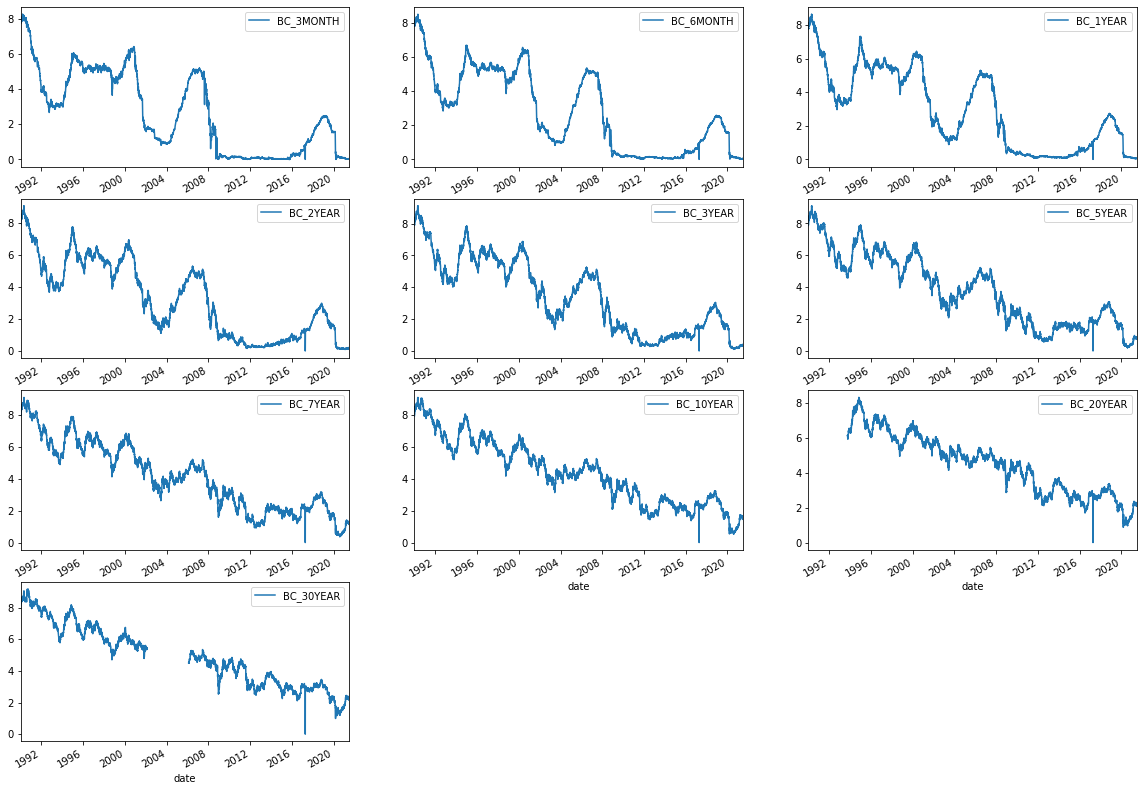

In [8]:
plt.figure(figsize = (20,15))
for i in range(len(df.columns)):
    plt.subplot(len(df.columns)//3+1,3,i+1)
    df.iloc[:,i].plot()
    plt.legend()    

In [9]:
# scan through the dataframe to find the the rates with 0s
df_rate0 = []
for i in range(10):
    df_rate0.append(df.iloc[:,i][df.iloc[:,i] == 0])

pd.concat(df_rate0, axis =1).replace(np.nan, '')

,BC_3MONTH,BC_6MONTH,BC_1YEAR,BC_2YEAR,BC_3YEAR,BC_5YEAR,BC_7YEAR,BC_10YEAR,BC_20YEAR,BC_30YEAR
date,,,,,,,,,,
2011-09-22,0.0,,,,,,,,,
2011-10-05,0.0,,,,,,,,,
2011-12-15,0.0,,,,,,,,,
2011-12-16,0.0,,,,,,,,,
2013-09-26,0.0,,,,,,,,,
2015-09-18,0.0,,,,,,,,,
2015-09-22,0.0,,,,,,,,,
2015-09-25,0.0,,,,,,,,,
2015-09-30,0.0,,,,,,,,,


Note:  
* 1 month TR only starts from 2001-07-01, so not included in the model
* 20 year TR has missing value from 1987Q1 to 1993Q3
  https://fred.stlouisfed.org/series/DGS20

* 30 year TR has missing value from 2002Q2 to 2005Q4
(The U.S Treasury suspended issuance of the 30 year bond between 3/2002 and 2/2006)

* 2017-04-14 '0.0' are not really 0% interest rate, but rather missing values. 

**So we will drop this one data points, '2017-04-14'**

In [10]:
df2 = df.drop(index = pd.Timestamp('2017-04-14'), axis = 0)

In [11]:
# verify '2017-04-14' record was dropped
df.loc['2017-04-14']
# df2.loc['2017-04-14']

BC_3MONTH    0.0
BC_6MONTH    0.0
BC_1YEAR     0.0
BC_2YEAR     0.0
BC_3YEAR     0.0
BC_5YEAR     0.0
BC_7YEAR     0.0
BC_10YEAR    0.0
BC_20YEAR    0.0
BC_30YEAR    0.0
Name: 2017-04-14 00:00:00, dtype: float64

For now, we only concern those with 0s who's nearby rates are significantly different than 0s. In other word, there is clear structural break in the data.

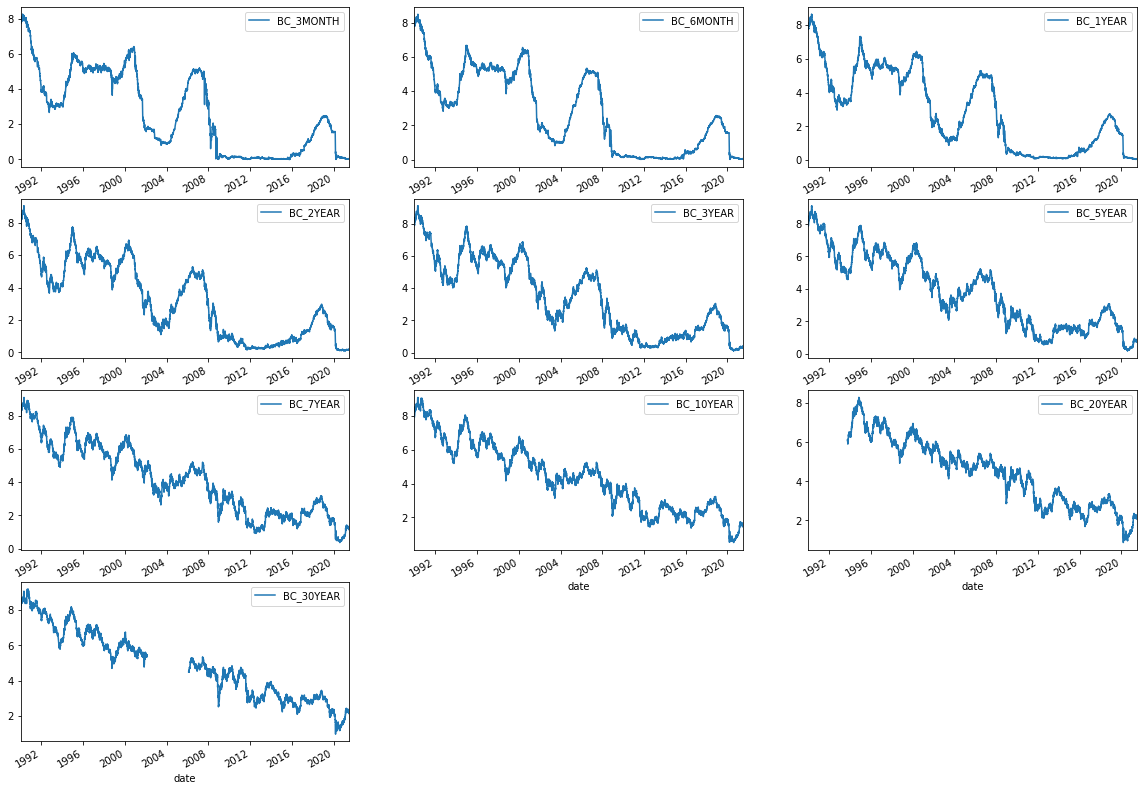

In [12]:
plt.figure(figsize = (20,15))
for i in range(len(df2.columns)):
    plt.subplot(len(df2.columns)//3+1,3,i+1)
    df2.iloc[:,i].plot()
    plt.legend()

##### Aggregating data into quarterly frequency, in order to match the other data we are going to discuss later.

In [13]:
TR_raw = df2.resample("Q").mean().round(4)
# TR_raw.to_excel("Treasury_yield_month_average.xlsx")  #write to excel if desired

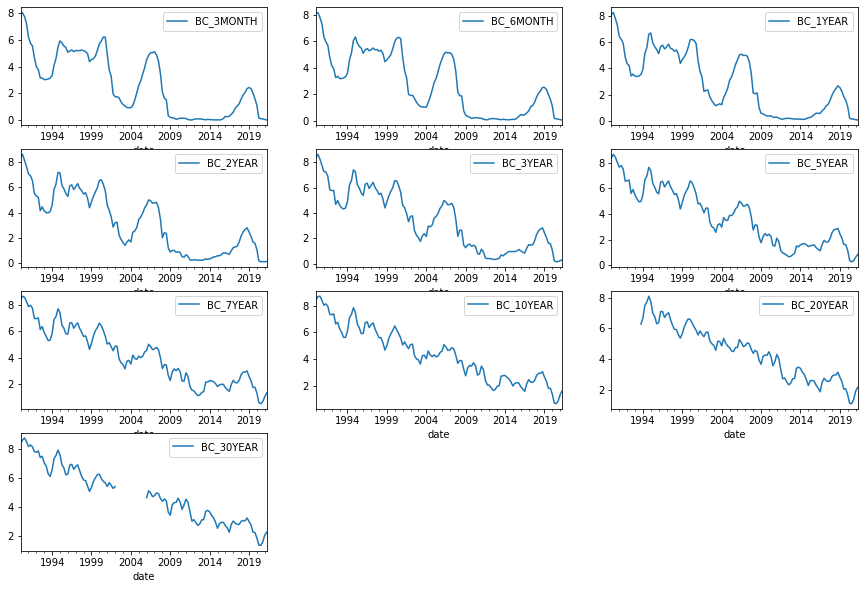

In [14]:
TR_no = len(TR_raw.columns)
plt.figure(figsize = (15,10))
for i in range(TR_no):
    plt.subplot(TR_no//3+1,3,i+1)
    TR_raw.iloc[:,i].plot()
    plt.legend()

Take a look at the head or tail to ensure good data quality

In [15]:
TR_raw.tail()

,BC_3MONTH,BC_6MONTH,BC_1YEAR,BC_2YEAR,BC_3YEAR,BC_5YEAR,BC_7YEAR,BC_10YEAR,BC_20YEAR,BC_30YEAR
date,,,,,,,,,,
2020-06-30,0.1422,0.1679,0.1743,0.1937,0.2408,0.3575,0.5421,0.6876,1.1540,1.3808
2020-09-30,0.1134,0.1267,0.1347,0.1409,0.1645,0.2717,0.4623,0.6506,1.1445,1.3630
2020-12-31,0.0929,0.1027,0.1145,0.1497,0.1965,0.3695,0.6156,0.8645,1.4040,1.6190
2021-03-31,0.0511,0.0662,0.0825,0.1321,0.2479,0.6180,1.0015,1.3359,1.9367,2.0866
2021-06-30,0.0209,0.0387,0.0554,0.1587,0.3335,0.8307,1.2781,1.6093,2.1922,2.2880


### Step 3-2 Data Cleaning 2

In [16]:
##  set initial date parameter (all in string format)
train_start = '1990-01-31'  # starting date for training sample 
train_end = '2018-12-31' # end date for training sample, match the macro economic factor ending date
pred_start = str(pd.to_datetime(train_end) + relativedelta(months=1))

In [17]:
# sampling the training data from the raw data
TR_qtrly = TR_raw.loc[train_start:train_end]
# simplify the column names
TR_qtrly.columns = ['BC3M', 'BC6M', 'BC1Y', 'BC2Y','BC3Y', 'BC5Y', 'BC7Y', 'BC10Y', 'BC20Y', 'BC30Y']
# rename the columns to be more precise yet understandable
TR_qtrly.tail()
# len(TR_qtrly)

,BC3M,BC6M,BC1Y,BC2Y,BC3Y,BC5Y,BC7Y,BC10Y,BC20Y,BC30Y
date,,,,,,,,,,
2017-12-31,1.2266,1.3761,1.5503,1.6944,1.8129,2.0692,2.2481,2.3715,2.6165,2.8168
2018-03-31,1.5821,1.7739,1.9425,2.1605,2.3067,2.5349,2.6839,2.7585,2.9046,3.0302
2018-06-30,1.8747,2.0553,2.2522,2.4770,2.6091,2.7656,2.8741,2.9206,2.9972,3.0853
2018-09-30,2.0746,2.2483,2.4602,2.6659,2.7435,2.8090,2.8822,2.9238,2.9963,3.0630
2018-12-31,2.3567,2.5028,2.6682,2.8028,2.8443,2.8836,2.9666,3.0411,3.1766,3.2707


In [18]:
TR_qtrly.isnull().sum()  # checking missing values

BC3M      0
BC6M      0
BC1Y      0
BC2Y      0
BC3Y      0
BC5Y      0
BC7Y      0
BC10Y     0
BC20Y    15
BC30Y    15
dtype: int64

In [19]:
TR_qtrly.describe() # data description

,BC3M,BC6M,BC1Y,BC2Y,BC3Y,BC5Y,BC7Y,BC10Y,BC20Y,BC30Y
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,101.000000,101.000000
mean,2.801282,2.938867,3.073399,3.391818,3.620103,4.032383,4.347886,4.591253,4.695821,5.156027
std,2.323285,2.355226,2.348363,2.355259,2.289600,2.145115,2.033941,1.905090,1.564433,1.812522
min,0.014800,0.049800,0.103000,0.257800,0.346700,0.668900,1.079800,1.564400,1.909800,2.280000
25%,0.282725,0.429450,0.570575,0.986550,1.449175,2.038875,2.466700,2.854925,3.177900,3.442500
50%,2.757950,3.026600,3.204900,3.472300,3.740400,4.062100,4.304800,4.532650,4.774000,4.994300
75%,5.032625,5.098550,5.131375,5.463000,5.593400,5.713575,5.964550,6.013650,5.888900,6.580500
max,8.026500,8.167500,8.271000,8.571100,8.622900,8.644300,8.704300,8.701300,8.087700,8.791600


In [20]:
TR_qtrly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116 entries, 1990-03-31 to 2018-12-31
Freq: Q-DEC
Data columns (total 10 columns):
BC3M     116 non-null float64
BC6M     116 non-null float64
BC1Y     116 non-null float64
BC2Y     116 non-null float64
BC3Y     116 non-null float64
BC5Y     116 non-null float64
BC7Y     116 non-null float64
BC10Y    116 non-null float64
BC20Y    101 non-null float64
BC30Y    101 non-null float64
dtypes: float64(10)
memory usage: 10.0 KB


#### Final review of data quality

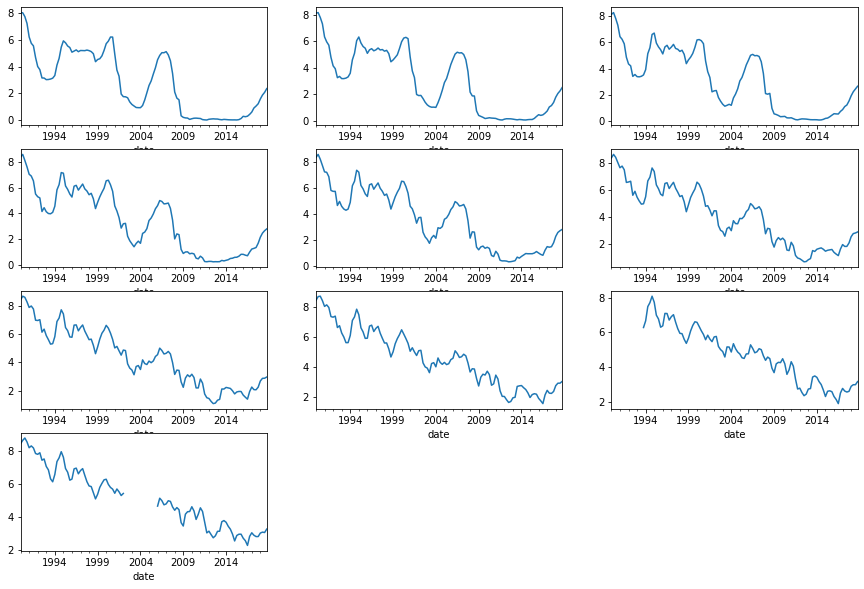

In [21]:
TR_no = len(TR_qtrly.columns)
plt.figure(figsize = (15,10))
for i in range(TR_no):
    plt.subplot(TR_no//3+1,3,i+1)
    TR_qtrly.iloc[:,i].plot()

## Section 2. Dynamic Nelson Siegel Model (Output: three Betas)

Key Reference Papers:  
(1) <a href="https://www.sciencedirect.com/science/article/pii/S0304407605000795">Forecasting the term structure of government bond yields</a>  
(2) <a href="https://www.sciencedirect.com/science/article/pii/S030440760500014X">The macroeconomy and the yield curve: a dynamic latent factor approach</a>

DNS Model | DNS Model (time variant)
- | - 
![alt](Input/DNS_Model.JPG) | ![alt](Input/DNS_Model_t.JPG)


For more details about the DNS/NS models, refer to appendix

### 2.1 DNS model with fixed Lambda 

The code below estimate the betas using a fixed lambda value based on the reference papers. The fixed Lambda is used to simplify the task

In [22]:
#=============================================================================================
# Nelson–Siegel model, detail see reference: https://comisef.eu/files/wps031.pdf
# Code below is modified from the R code in the reference link
#=============================================================================================

def factorBeta1(lambda_var, maturity):
    return np.divide((1-np.exp(-np.multiply(lambda_var, maturity))), (np.multiply(lambda_var, maturity)))

def factorBeta2(lambda_var, maturity):
    return np.divide((1-np.exp(-np.multiply(lambda_var, maturity))), (np.multiply(lambda_var, maturity))) - np.exp(-np.multiply(lambda_var, maturity))

# def factorBeta2neg(lambda_var, maturity):
#     return np.negative(np.divide((1-np.exp(-np.multiply(lambda_var, maturity))), (np.multiply(lambda_var, maturity))) - np.exp(-np.multiply(lambda_var, maturity)))

def ns_estimator(rate, maturity, lambda_var):
    model = sm.OLS(rate.values.reshape(len(rate),1), sm.add_constant(
        np.column_stack(
            (factorBeta1(lambda_var,maturity),
             factorBeta2(lambda_var,maturity)))))
    beta = model.fit()
    betaPar = beta.params
    estResults = {'Par': betaPar, 'Res': beta.resid}
    return estResults

In [23]:
lambda_fix = 0.0609 # for simplicity, we will use fixed lambda as given by the paper

Target_Maturity = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])*12  # list of maturities

# create an empty dataframe `DNS_betas` as place holder. The dataframe can be used to store all the betas results
DNS_betas = pd.DataFrame(data = np.zeros((len(TR_qtrly), 3)), columns = ["beta0","beta1","beta2"])
DNS_betas.index = TR_qtrly.index
DNS_betas.head()  #empty matrix as a place holder

,beta0,beta1,beta2
date,,,
1990-03-31,0.0,0.0,0.0
1990-06-30,0.0,0.0,0.0
1990-09-30,0.0,0.0,0.0
1990-12-31,0.0,0.0,0.0
1991-03-31,0.0,0.0,0.0


In [24]:
j=0
while j < len(TR_qtrly):
    rate_temp = TR_qtrly.iloc[j][~TR_qtrly.iloc[j].isnull()]
    maturity_temp = Target_Maturity[~TR_qtrly.iloc[j].isnull()]  #for each month filter out the missing values 
    DNS_betas.iloc[j] = ns_estimator(rate_temp, maturity_temp , lambda_var = lambda_fix)['Par']
    j += 1

 The `DNS_betas` dataframe contains the betas for modeling tasks

In [25]:
DNS_betas.head()

,beta0,beta1,beta2
date,,,
1990-03-31,8.435314,-0.488846,0.470636
1990-06-30,8.640866,-0.773451,1.009996
1990-09-30,8.920599,-1.274967,-0.545267
1990-12-31,8.733257,-1.558480,-1.083104
1991-03-31,8.395499,-2.407484,-0.466384


#### Data Quality Check for betas

First, plotting for overviews

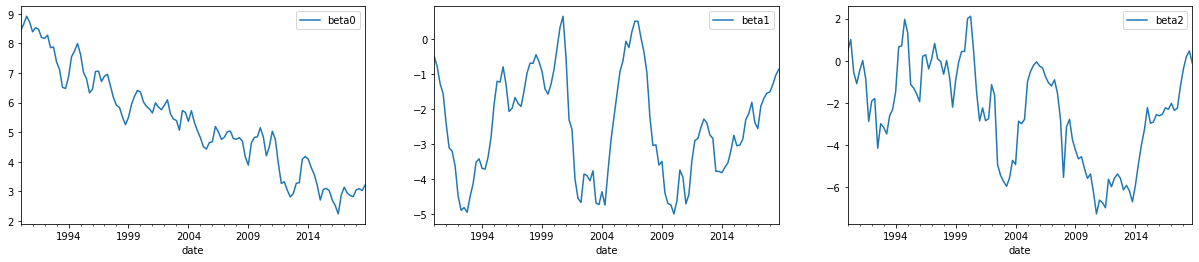

In [26]:
plt.figure(figsize = (21,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    DNS_betas.iloc[:, i].plot()
    plt.legend()

Check the null/missing values (should not be any)

In [27]:
DNS_betas.isnull().sum()

beta0    0
beta1    0
beta2    0
dtype: int64

A third way to check the quality of data as suggested by the paper

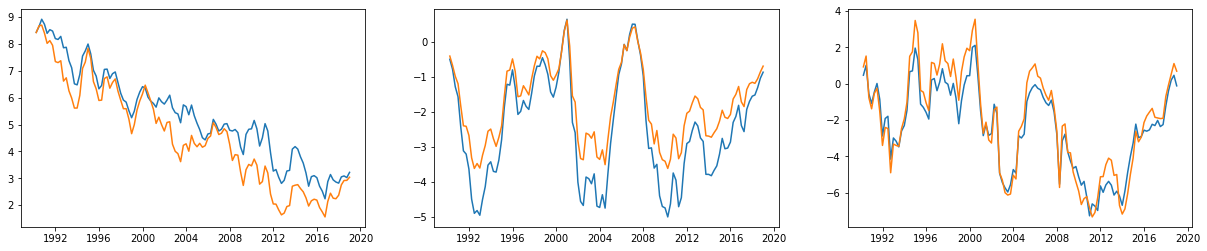

In [28]:
TR_qtrly_DQ = TR_qtrly.loc[:,['BC3M', 'BC2Y', 'BC10Y']] #DQ : Data Quality, not ice cream store

TR_qtrly_DQ.index = TR_qtrly.index.to_period('M').to_timestamp('M')  # make sure date is the same

DNS_betas_DQ = DNS_betas.copy().join(TR_qtrly_DQ) 

DNS_betas_DQ['Level'] = DNS_betas_DQ['BC10Y']
DNS_betas_DQ['Slope'] = DNS_betas_DQ['BC3M'] - DNS_betas_DQ['BC10Y'] 
DNS_betas_DQ['Curvature'] = (2*DNS_betas_DQ['BC2Y'] - DNS_betas_DQ['BC3M'] - DNS_betas_DQ['BC10Y'])/0.3

plt.figure(figsize = (21,4))
plt.subplot(1,3,1)
plt.plot(DNS_betas_DQ.loc[:,['beta0', 'Level']]['1986-01-31':])
plt.subplot(1,3,2)
plt.plot(DNS_betas_DQ.loc[:,['beta1', 'Slope']]['1986-01-31':])
plt.subplot(1,3,3)
plt.plot(DNS_betas_DQ.loc[:,['beta2', 'Curvature']]['1986-01-31':])

#### Hint: 2.	For modeling task, only "beta0" is not stationary (and therefore requires transformation, make the best transformation as you see fit. The most common ones are first difference or log difference), "beta1" & "beta2" are both stationary. However, your answers have to provide evidences to support the argument.

For the project, your will use what you learned from the class to perform the following tasks:  
* Using the time series method (either OLS or ARIMAX) that was taught in class to model the three betas using macroeconomic variables. Three separate models (one for each beta) will be required. Select the predict variables (macro-economic variables provided) using the techniques taught in class. You are welcome to explore time series method other than OLS and ARIMAX, but you are responsible to demonstrate why the alternative method you picked is better than OLS/ARIMAX.
* Forecast the Baseline betas (one scenario only, no need for stress scenario) from quarter 2019Q1 to 2022Q1 using the corresponding macro-economic variables forecasts (“Table_2A_Supervisory_Baseline_Domestic.csv”).
* Using the predicted betas to produce the yield curve/interest forecasts for all the maturities (“BC_3MONTH, BC_6MONTH, BC_1YEAR, BC_2YEAR, BC_3YEAR, BC_5YEAR, BC_7YEAR, BC_10YEAR, BC_20YEAR, BC_30YEAR”) using the above formula (1). You are encouraged to leverage the “factorBeta1” and “factorBeta2” function.
* Show at least two candidates (two sets of variables) for each beta model and select the final models based on your candidates. Provide strong rationale why one is better than the other. 
* Plotting all the historical and forecast results, as well as key statistical test (as taught in class).

## Section 3. Reading in Historic Data and Creating Forecast

### First, I read in the necessary historic economic data to be used in the model for time series forecasting

In [29]:
MACRO = pd.read_csv('Historic_Domestic.csv') # macro economic data
MACRO_DATA = MACRO.drop(MACRO.index[0:57])
MACRO_DATA["Quarters"] = MACRO['Date'].str[0:4] + MACRO['Date'].str[-2:]
MACRO_DATA.index = pd.to_datetime(MACRO_DATA.Quarters) +pd.offsets.QuarterEnd(0)
MACRO_DATA.head()

,Scenario Name,Date,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury rate,5-year Treasury yield,10-year Treasury yield,BBB corporate yield,Mortgage rate,Prime rate,Dow Jones Total Stock Market Index (Level),House Price Index (Level),Commercial Real Estate Price Index (Level),Market Volatility Index (Level),Quarters
Quarters,,,,,,,,,,,,,,,,,,,
1990-06-30,Actual,1990 Q2,1.5,6.1,2.8,6.6,5.3,4.0,7.7,8.7,8.8,10.2,10.3,10.0,3424.4,76.2,107.5,24.2,1990Q2
1990-09-30,Actual,1990 Q3,0.3,3.7,-0.1,5.0,5.7,7.1,7.5,8.5,8.8,10.2,10.1,10.0,2879.3,75.9,107.0,36.5,1990Q3
1990-12-31,Actual,1990 Q4,-3.6,-0.7,-3.4,1.8,6.1,7.0,7.0,8.1,8.5,10.3,10.0,10.0,3101.4,75.5,106.6,34.0,1990Q4
1991-03-31,Actual,1991 Q1,-1.9,2.0,1.0,3.1,6.6,3.0,6.0,7.7,8.2,9.9,9.5,9.2,3583.7,75.1,105.6,36.2,1991Q1
1991-06-30,Actual,1991 Q2,3.2,6.2,2.9,5.2,6.8,2.4,5.6,7.8,8.3,9.7,9.5,8.7,3545.5,75.3,104.6,20.1,1991Q2


In [30]:
# transforming X variables and creating more relevant variables to try during the OLS

# difference transformations
MACRO_DATA['MR_diff'] = MACRO_DATA['Mortgage rate'].diff()
MACRO_DATA['UR_diff'] = MACRO_DATA['Unemployment rate'].diff()
MACRO_DATA['CPI_diff'] = MACRO_DATA['CPI inflation rate'].diff()
MACRO_DATA['TR5YR_diff'] = MACRO_DATA['5-year Treasury yield'].diff()
MACRO_DATA['TR10YR_diff'] = MACRO_DATA['10-year Treasury yield'].diff()
MACRO_DATA['BBB_diff'] = MACRO_DATA['BBB corporate yield'].diff()
MACRO_DATA['HPI_diff'] = MACRO_DATA['House Price Index (Level)'].diff()

# percentage transformations
MACRO_DATA['MR_pct'] = MACRO_DATA['Mortgage rate'].pct_change()*100
MACRO_DATA['HPI_pct'] = MACRO_DATA['House Price Index (Level)'].pct_change()*100
MACRO_DATA['DJTSM_pct'] = MACRO_DATA['Dow Jones Total Stock Market Index (Level)'].pct_change()*100
MACRO_DATA['UR_pct'] = MACRO_DATA['Unemployment rate'].pct_change()*100

# difference and lag transformations
MACRO_DATA['UR_diff_lag1'] = MACRO_DATA['UR_diff'].shift()
MACRO_DATA['MR_diff_lag1'] = MACRO_DATA['MR_diff'].shift()
MACRO_DATA['HPI_pct_lag1'] = MACRO_DATA['HPI_pct'].shift()
MACRO_DATA['MR_pct_lag1'] = MACRO_DATA['MR_pct'].shift()
MACRO_DATA['UR_pct_lag1'] = MACRO_DATA['UR_pct'].shift()

# difference and lag transformations
MACRO_DATA['UR_diff_lag2'] = MACRO_DATA['UR_diff'].shift(2)
MACRO_DATA['MR_diff_lag2'] = MACRO_DATA['MR_diff'].shift(2)
MACRO_DATA['HPI_pct_lag2'] = MACRO_DATA['HPI_pct'].shift(2)
MACRO_DATA['MR_pct_lag2'] = MACRO_DATA['MR_pct'].shift(2)
MACRO_DATA['UR_pct_lag2'] = MACRO_DATA['UR_pct'].shift(2)

# create a constant for use during the OLS
MACRO_DATA.insert(0, 'const', 1)

In [31]:
# get some general information of the DNS dataframe that was created by instructor
DNS_betas.info

<bound method DataFrame.info of                beta0     beta1     beta2
date                                    
1990-03-31  8.435314 -0.488846  0.470636
1990-06-30  8.640866 -0.773451  1.009996
1990-09-30  8.920599 -1.274967 -0.545267
1990-12-31  8.733257 -1.558480 -1.083104
1991-03-31  8.395499 -2.407484 -0.466384
...              ...       ...       ...
2017-12-31  2.821611 -1.543853 -1.220794
2018-03-31  3.054071 -1.508942 -0.390328
2018-06-30  3.089606 -1.299449  0.202055
2018-09-30  3.028488 -1.027960  0.465486
2018-12-31  3.222792 -0.857309 -0.114341

[116 rows x 3 columns]>

In [32]:
# Do the same for the historic Macro Data
MACRO_DATA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115 entries, 1990-06-30 to 2018-12-31
Data columns (total 41 columns):
const                                         115 non-null int64
Scenario Name                                 115 non-null object
Date                                          115 non-null object
Real GDP growth                               115 non-null float64
Nominal GDP growth                            115 non-null float64
Real disposable income growth                 115 non-null float64
Nominal disposable income growth              115 non-null float64
Unemployment rate                             115 non-null float64
CPI inflation rate                            115 non-null float64
3-month Treasury rate                         115 non-null float64
5-year Treasury yield                         115 non-null float64
10-year Treasury yield                        115 non-null float64
BBB corporate yield                           115 non-null float64
Mortgage 

As given in the hint, beta0 is not stationary. It has to be made stationary before modeling. In order to make the data for beta0 stationary, I take the first difference of the beta0 variable. This is the simplest transformation I can make.

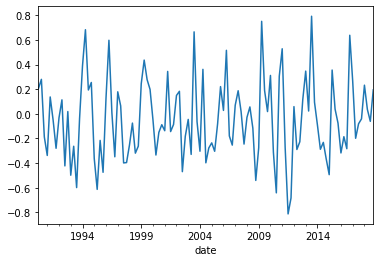

In [33]:
DNS_betas_diff = DNS_betas['beta0'].diff().iloc[1:]

# Plotting to check stationarity
DNS_betas_diff.plot(kind='line', y='beta0')

Beta0 now appears to be stationary as beta1 and beta2.

### Testing possible models for forecasting using linear regression


* Variables chosen by running different models using different variables. Two candidates will be shown for each beta and the best one will be chosen from the two

In [34]:
# First possible model for beta0
B0_variables_1 = ['const','UR_diff_lag2','Real GDP growth','BBB_diff']
B0_ECON_OLS_1 = sm.OLS(DNS_betas_diff, MACRO_DATA[B0_variables_1], missing = 'drop')
B0_ECON_OLS_FIT_1 = B0_ECON_OLS_1.fit()
B0_ECON_OLS_FIT_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  beta0   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     14.49
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           5.35e-08
Time:                        21:49:44   Log-Likelihood:                -13.135
No. Observations:                 112   AIC:                             34.27
Df Residuals:                     108   BIC:                             45.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1094      0.039     -2.784      0.006      -0.187      -0.032
UR_diff_lag2        0.3372      0.097      3.470      0.001       0.145       0.530
Real GDP growth     0.0323      0.012      2.790      0.006       0.009       0.055
BBB_diff            0.3874      0.064      6.075      0.000       0.261       0.514
==============================================================================
Omnibus:                       12.712   Durbin-Watson:                   1.603
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.753
Skew:                          -0.305   Prob(JB):                     2.10e-07
Kurtosis:                       5.494   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

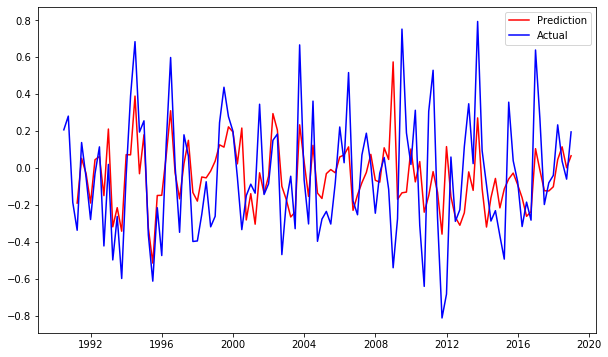

In [35]:
B0_predicted_1 = B0_ECON_OLS_FIT_1.predict(MACRO_DATA[B0_variables_1])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(B0_predicted_1, 'r-', label="Prediction")
ax.plot(DNS_betas_diff, 'b-', label="Actual")
ax.legend(loc="best");

In [36]:
#  Second possible model for beta0
B0_variables_2 = ['const','Unemployment rate','CPI inflation rate','BBB_diff']
B0_ECON_OLS_2 = sm.OLS(DNS_betas_diff, MACRO_DATA[B0_variables_2], missing = 'drop')
B0_ECON_OLS_FIT_2 = B0_ECON_OLS_2.fit()
B0_ECON_OLS_FIT_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  beta0   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     16.10
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           9.54e-09
Time:                        21:49:47   Log-Likelihood:                -11.505
No. Observations:                 114   AIC:                             31.01
Df Residuals:                     110   BIC:                             41.95
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.3451      0.113     -3.051      0.003      -0.569      -0.121
Unemployment rate      0.0292      0.017      1.709      0.090      -0.005       0.063
CPI inflation rate     0.0595      0.014      4.392      0.000       0.033       0.086
BBB_diff               0.3941      0.064      6.189      0.000       0.268       0.520
==============================================================================
Omnibus:                        8.057   Durbin-Watson:                   1.190
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               16.322
Skew:                           0.036   Prob(JB):                     0.000286
Kurtosis:                       4.852   Cond. No.                         30.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

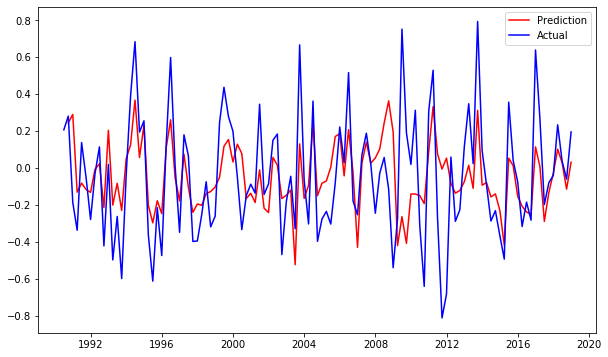

In [37]:
B0_predicted_2 = B0_ECON_OLS_FIT_2.predict(MACRO_DATA[B0_variables_2])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(B0_predicted_2, 'r-', label="Prediction")
ax.plot(DNS_betas_diff, 'b-', label="Actual")
ax.legend(loc="best");

#### Both models appear similar however, it looks as if the first model better predicts some of the larger fluctuations such as the one around 2008. Because, of this the first model will be chosen for Beta0

In [38]:
# First possible model for beta1

B1_variables_1 = ['const','UR_diff_lag2','Prime rate', 'Real GDP growth']
B1_ECON_OLS_1 = sm.OLS(DNS_betas['beta1'].iloc[1:], MACRO_DATA[B1_variables_1], missing = 'drop')
B1_ECON_OLS_FIT_1 = B1_ECON_OLS_1.fit()
B1_ECON_OLS_FIT_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  beta1   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     37.95
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           7.88e-17
Time:                        21:49:50   Log-Likelihood:                -164.35
No. Observations:                 112   AIC:                             336.7
Df Residuals:                     108   BIC:                             347.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.9455      0.296    -16.701      0.000      -5.532      -4.359
UR_diff_lag2       -1.7297      0.357     -4.839      0.000      -2.438      -1.021
Prime rate          0.4478      0.048      9.324      0.000       0.353       0.543
Real GDP growth    -0.0786      0.045     -1.733      0.086      -0.169       0.011
==============================================================================
Omnibus:                       10.394   Durbin-Watson:                   0.307
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                4.408
Skew:                          -0.210   Prob(JB):                        0.110
Kurtosis:                       2.124   Cond. No.                         24.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

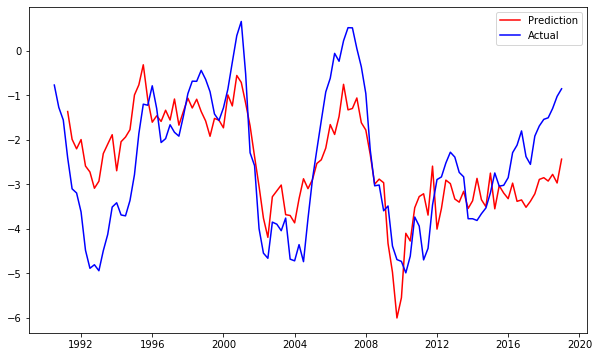

In [39]:
B1_predicted_1 = B1_ECON_OLS_FIT_1.predict(MACRO_DATA[B1_variables_1])
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(B1_predicted_1, 'r-', label="Prediction")
ax.plot(DNS_betas['beta1'].iloc[1:], 'b-', label="Actual")
ax.legend(loc="best");

In [40]:
#  Second possible model for beta1

B1_variables_2 = ['const','UR_diff_lag2','Prime rate','House Price Index (Level)']
B1_ECON_OLS_2 = sm.OLS(DNS_betas['beta1'].iloc[1:], MACRO_DATA[B1_variables_2], missing = 'drop')
B1_ECON_OLS_FIT_2 = B1_ECON_OLS_2.fit()
B1_ECON_OLS_FIT_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  beta1   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     141.8
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           2.62e-37
Time:                        21:49:51   Log-Likelihood:                -115.23
No. Observations:                 112   AIC:                             238.5
Df Residuals:                     108   BIC:                             249.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -9.5721      0.405    -23.648      0.000     -10.374      -8.770
UR_diff_lag2                 -1.0269      0.231     -4.452      0.000      -1.484      -0.570
Prime rate                    0.6732      0.036     18.746      0.000       0.602       0.744
House Price Index (Level)     0.0237      0.002     12.604      0.000       0.020       0.027
==============================================================================
Omnibus:                        1.990   Durbin-Watson:                   0.427
Prob(Omnibus):                  0.370   Jarque-Bera (JB):                1.917
Skew:                           0.240   Prob(JB):                        0.383
Kurtosis:                       2.574   Cond. No.                         870.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

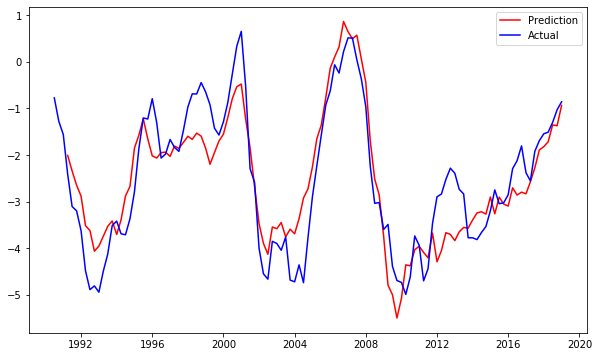

In [41]:
B1_predicted_2 = B1_ECON_OLS_FIT_2.predict(MACRO_DATA[B1_variables_2])
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(B1_predicted_2, 'r-', label="Prediction")
ax.plot(DNS_betas['beta1'].iloc[1:], 'b-', label="Actual")
ax.legend(loc="best");

### The second model for beta1 will be chosen due to its higher accuracy

In [42]:
# First possible model for beta2

B2_variables_1 = ['const','TR5YR_diff', 'MR_pct_lag1', 'Prime rate']
B2_ECON_OLS_1= sm.OLS(DNS_betas['beta2'].iloc[1:], MACRO_DATA[B2_variables_1], missing = 'drop')
B2_ECON_OLS_FIT_1 = B2_ECON_OLS_1.fit()
B2_ECON_OLS_FIT_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  beta2   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     86.84
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           8.97e-29
Time:                        21:49:54   Log-Likelihood:                -186.74
No. Observations:                 113   AIC:                             381.5
Df Residuals:                     109   BIC:                             392.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -7.1777      0.348    -20.623      0.000      -7.868      -6.488
TR5YR_diff      1.8522      0.304      6.099      0.000       1.250       2.454
MR_pct_lag1     0.0669      0.022      2.975      0.004       0.022       0.111
Prime rate      0.8335      0.056     14.863      0.000       0.722       0.945
==============================================================================
Omnibus:                        0.289   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.866   Jarque-Bera (JB):                0.055
Skew:                          -0.021   Prob(JB):                        0.973
Kurtosis:                       3.100   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

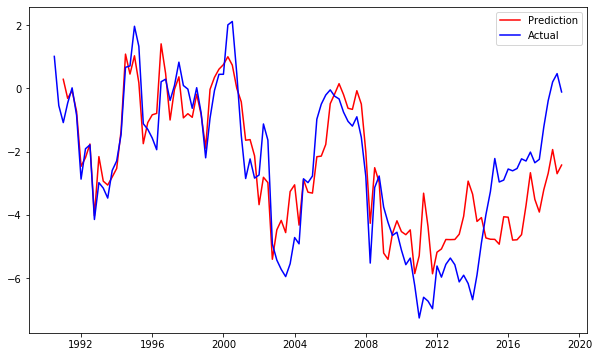

In [43]:
B2_predicted_1 = B2_ECON_OLS_FIT_1.predict(MACRO_DATA[B2_variables_1])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(B2_predicted_1, 'r-', label="Prediction")
ax.plot(DNS_betas['beta2'].iloc[1:], 'b-', label="Actual")
ax.legend(loc="best");

In [44]:
# Second possible model for beta2

B2_variables_2 = ['const', 'MR_pct_lag1', 'Prime rate']
B2_ECON_OLS_2 = sm.OLS(DNS_betas['beta2'].iloc[1:], MACRO_DATA[B2_variables_2], missing = 'drop')
B2_ECON_OLS_FIT_2 = B2_ECON_OLS_2.fit()
B2_ECON_OLS_FIT_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  beta2   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     84.02
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           7.10e-23
Time:                        21:49:55   Log-Likelihood:                -203.33
No. Observations:                 113   AIC:                             412.7
Df Residuals:                     110   BIC:                             420.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -7.0203      0.400    -17.545      0.000      -7.813      -6.227
MR_pct_lag1     0.0809      0.026      3.138      0.002       0.030       0.132
Prime rate      0.7920      0.064     12.342      0.000       0.665       0.919
==============================================================================
Omnibus:                        2.065   Durbin-Watson:                   0.518
Prob(Omnibus):                  0.356   Jarque-Bera (JB):                1.509
Skew:                           0.042   Prob(JB):                        0.470
Kurtosis:                       2.440   Cond. No.                         18.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

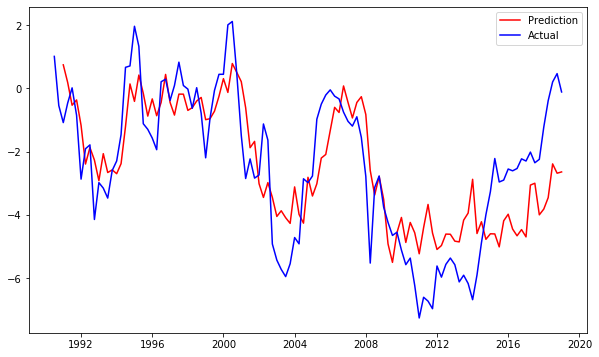

In [45]:
B2_predicted_2 = B2_ECON_OLS_FIT_2.predict(MACRO_DATA[B2_variables_2])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(B2_predicted_2, 'r-', label="Prediction")
ax.plot(DNS_betas['beta2'].iloc[1:], 'b-', label="Actual")
ax.legend(loc="best");

### It appears that the first model may be overfitted due to the inclusion of the treasury yield. Because of this, the second model will be used instead of the first for Beta2

## Baseline Forecast

#### Now having chosen a few models, import the forecast data

In [46]:
# reading the data and getting the appropriate datetime index
Econ_Base_fcst=pd.read_csv('Table_2A_Supervisory_Baseline_Domestic.csv')
Econ_Base_fcst["Quarters"]=Econ_Base_fcst['Date'].str[0:4] + Econ_Base_fcst['Date'].str[
-2:]
Econ_Base_fcst.index = pd.to_datetime(Econ_Base_fcst.Quarters)

# manipulating the original historic dataframe in order to merge the two together
MACRO["Quarters"] = MACRO['Date'].str[0:4] + MACRO['Date'].str[-2:]
MACRO.index = pd.to_datetime(MACRO.Quarters)

# merging the datasets
Econ_Base = MACRO.append(Econ_Base_fcst)

# resetting the index to ensure there is no discrepency in the merged dataset
Econ_Base.index = pd.to_datetime(Econ_Base.Quarters) +pd.offsets.QuarterEnd(0)
Base_end = Econ_Base.index[-1]

# get an idea of what the dataframe looks like
Econ_Base.head()

,Scenario Name,Date,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury rate,5-year Treasury yield,10-year Treasury yield,BBB corporate yield,Mortgage rate,Prime rate,Dow Jones Total Stock Market Index (Level),House Price Index (Level),Commercial Real Estate Price Index (Level),Market Volatility Index (Level),Quarters
Quarters,,,,,,,,,,,,,,,,,,,
1976-03-31,Actual,1976 Q1,9.3,14.0,4.9,9.6,7.7,4.7,4.9,7.4,7.6,9.4,8.9,6.8,NaN,23.4,50.9,NaN,1976Q1
1976-06-30,Actual,1976 Q2,3.0,7.2,2.3,5.8,7.6,3.6,5.2,7.4,7.6,9.4,8.8,6.9,NaN,23.6,51.8,NaN,1976Q2
1976-09-30,Actual,1976 Q3,2.2,7.6,3.2,9.6,7.7,6.5,5.2,7.3,7.6,9.1,9.0,7.1,NaN,24.5,52.6,NaN,1976Q3
1976-12-31,Actual,1976 Q4,2.9,10.5,2.6,9.2,7.8,5.9,4.7,6.5,7.1,8.8,8.8,6.5,NaN,25.5,53.4,NaN,1976Q4
1977-03-31,Actual,1977 Q1,4.8,11.7,0.9,8.4,7.5,7.5,4.6,6.8,7.2,8.8,8.7,6.3,NaN,26.5,55.0,NaN,1977Q1


In [47]:
Econ_Base.tail()

,Scenario Name,Date,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury rate,5-year Treasury yield,10-year Treasury yield,BBB corporate yield,Mortgage rate,Prime rate,Dow Jones Total Stock Market Index (Level),House Price Index (Level),Commercial Real Estate Price Index (Level),Market Volatility Index (Level),Quarters
Quarters,,,,,,,,,,,,,,,,,,,
2021-03-31,Supervisory Baseline,2021 Q1,2.2,4.3,2.3,4.4,3.9,2.2,2.8,3.3,3.4,5.2,4.9,5.8,28528.5,217.3,321.9,24.6,2021Q1
2021-06-30,Supervisory Baseline,2021 Q2,2.0,4.1,2.2,4.2,4.0,2.2,2.8,3.3,3.5,5.1,5.0,5.8,28857.6,219.0,324.3,23.8,2021Q2
2021-09-30,Supervisory Baseline,2021 Q3,2.0,4.1,2.2,4.2,4.0,2.2,2.8,3.4,3.5,5.2,5.0,5.8,29190.5,220.6,326.8,23.7,2021Q3
2021-12-31,Supervisory Baseline,2021 Q4,2.0,4.1,2.2,4.2,4.0,2.2,2.8,3.4,3.5,5.2,5.0,5.8,29527.2,222.3,329.3,23.6,2021Q4
2022-03-31,Supervisory Baseline,2022 Q1,2.0,4.1,2.2,4.2,4.1,2.2,2.8,3.4,3.6,5.2,5.1,5.8,29867.5,223.9,331.7,23.6,2022Q1


In [48]:
# transforming the x-variables similar to how the historic data 'Macro' was transformed
Econ_Base['MR_diff'] = Econ_Base['Mortgage rate'].diff()
Econ_Base['UR_diff'] = Econ_Base['Unemployment rate'].diff()
Econ_Base['TR5YR_diff'] = Econ_Base['5-year Treasury yield'].diff()
Econ_Base['TR10YR_diff'] = Econ_Base['10-year Treasury yield'].diff()
Econ_Base['BBB_diff'] = Econ_Base['BBB corporate yield'].diff()
Econ_Base['HPI_diff'] = Econ_Base['House Price Index (Level)'].diff()
Econ_Base['HPI_logdiff'] = np.log(Econ_Base['House Price Index (Level)']).diff()

Econ_Base['DJTSM_pct'] = Econ_Base['Dow Jones Total Stock Market Index (Level)'].pct_change()*100
Econ_Base['HPI_pct'] = Econ_Base['House Price Index (Level)'].pct_change()*100
Econ_Base['UR_pct'] = Econ_Base['Unemployment rate'].pct_change()*100
Econ_Base['UR_diff_lag1'] = Econ_Base['UR_diff'].shift()
Econ_Base['MR_pct'] = Econ_Base['Unemployment rate'].pct_change()*100

# adding a constant and dummy to the data
Econ_Base['const'] = 1
Econ_Base['Dummy1'] = 0


Econ_Base['UR_diff_lag1'] = Econ_Base['UR_diff'].shift()
Econ_Base['MR_diff_lag1'] = Econ_Base['MR_diff'].shift()
Econ_Base['HPI_pct_lag1'] = Econ_Base['HPI_pct'].shift()
Econ_Base['MR_pct_lag1'] = Econ_Base['MR_pct'].shift()
Econ_Base['UR_pct_lag1'] = Econ_Base['UR_pct'].shift()


Econ_Base['UR_diff_lag2'] = Econ_Base['UR_diff'].shift(2)
Econ_Base['MR_diff_lag2'] = Econ_Base['MR_diff'].shift(2)
Econ_Base['HPI_pct_lag2'] = Econ_Base['HPI_pct'].shift(2)
Econ_Base['MR_pct_lag2'] = Econ_Base['MR_pct'].shift(2)
Econ_Base['UR_pct_lag2'] = Econ_Base['UR_pct'].shift(2)

# create a value to be added to the historic data using the OLS prediction
y_OOT_Base_0 = B0_ECON_OLS_FIT_1.predict(Econ_Base[train_end:][B0_variables_1])
y_OOT_Base_1 = B1_ECON_OLS_FIT_2.predict(Econ_Base[train_end:][B1_variables_2])
y_OOT_Base_2 = B2_ECON_OLS_FIT_2.predict(Econ_Base[train_end:][B2_variables_2])

In [49]:
# Specifying the actual forecast to be graphed 
B0_Base_fcst = DNS_betas['beta0'][-1] + y_OOT_Base_0.cumsum()
B1_Base_fcst = DNS_betas['beta1'][-1] + y_OOT_Base_1.cumsum()
B2_Base_fcst = DNS_betas['beta2'][-1] + y_OOT_Base_2.cumsum()

### Plotting Forecast

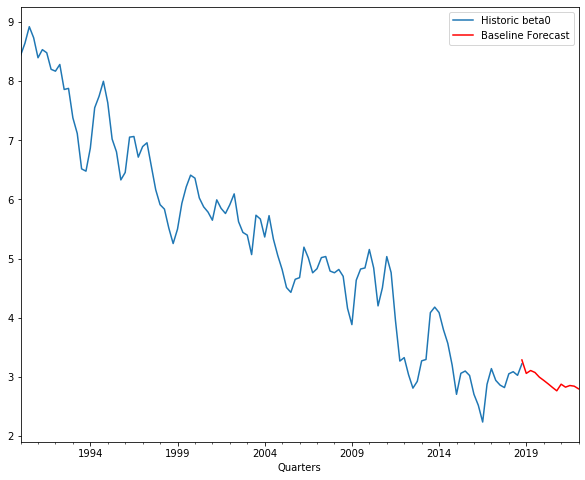

In [50]:
# Plotting Forecast for beta0 based on ols model
DNS_betas['beta0'].plot(figsize = (10,8), label = 'Historic beta0')
B0_Base_fcst.plot(color = 'r', label = 'Baseline Forecast')
plt.legend()

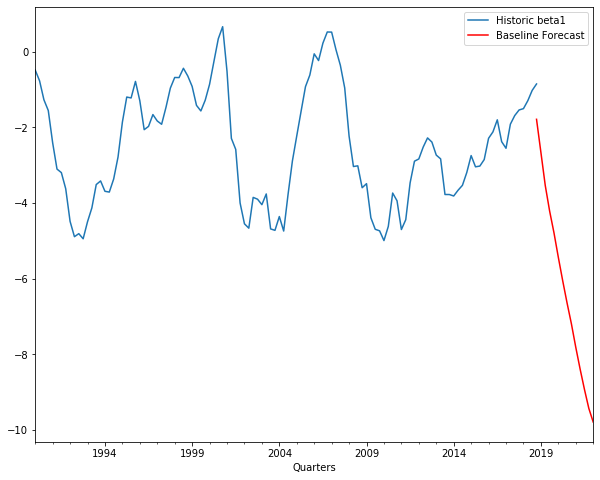

In [51]:
DNS_betas['beta1'].plot(figsize = (10,8), label = 'Historic beta1')
B1_Base_fcst.plot(color = 'r', label = 'Baseline Forecast')
plt.legend()


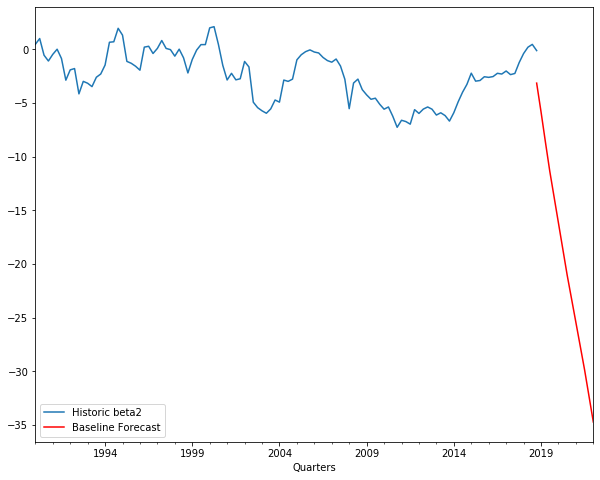

In [52]:
DNS_betas['beta2'].plot(figsize = (10,8), label = 'Historic beta2')
B2_Base_fcst.plot(color = 'r', label = 'Baseline Forecast')
plt.legend()


### Graphs of beta1 and beta2 were plotted incorrectly using stationary data. Beta1 and Beta2 need to be be made non-stationary in order to match the forecast modeled

* One possible way to solve is to find the sum of the changes in beta1 and beta2 in order to get a visual representation like beta0

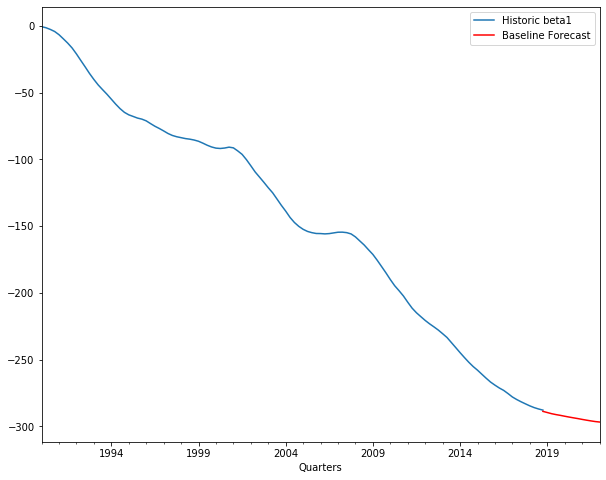

In [53]:
# find the sum of the changes to beta1
B1_sum = DNS_betas['beta1'].cumsum()

# create a forecast based on the sum instead of the original unchanged data
B1_sum_fcst = B1_sum[-1] + y_OOT_Base_1.cumsum()

# Plot the new forecase and see if it yields a more accurate prediction
B1_sum.plot(figsize = (10,8), label = 'Historic beta1')
B1_sum_fcst.plot(color = 'r', label = 'Baseline Forecast')
plt.legend()

### Making beta1 non-stationary provided the correct output. Repeat for beta2

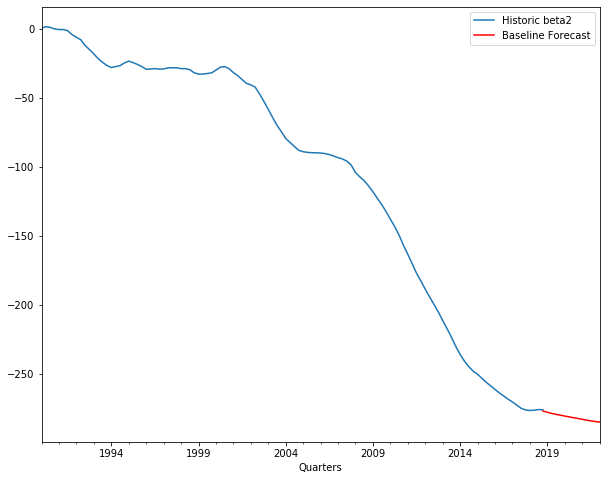

In [52]:
# Same steps as beta1
B2_sum = DNS_betas['beta2'].cumsum()
B2_sum_fcst = B2_sum[-1] + y_OOT_Base_1.cumsum()
B2_sum.plot(figsize = (10,8), label = 'Historic beta2')
B2_sum_fcst.plot(color = 'r', label = 'Baseline Forecast')
plt.legend()